 # Data Science Report



 This report analyzes the relationship between motion sensor events and weather conditions on weekends. The data is sourced from SmartThings sensors and weather data, which are merged and analyzed to understand the impact of temperature and rain on motion events.

 ## Initialize Database Connection and Load the Data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import poisson, negativebinomial
from scipy.stats import chisquare, shapiro, poisson, probplot
import scipy.stats as stats
from scipy.optimize import minimize
from IPython.display import display
from home_messages_db import HomeMessagesDB

# Initialize database connection
db = HomeMessagesDB('sqlite:///myhome.db')

# Load the data
df_smartthings = db.get_smartthings()
df_weather = db.get_weather_data()

 ## Prepare the Data

 First, we convert the epoch times in the SmartThings and weather datasets to datetime formats. We then identify weekends, as our analysis focuses on these days (during weekdays working people most likely have similar movement patterns regardless of the weather). Filtering the SmartThings data for 'active' motion sensor events ensures we are analyzing relevant motion events. We merge this filtered dataset with the weather data based on the nearest datetime to align motion events with corresponding weather conditions. Finally, we filter the merged dataset to include only weekend data and calculate daily aggregates of motion events and average weather conditions.

In [42]:
# Convert epoch time to datetime in df_smartthings and df_weather
df_smartthings['datetime'] = pd.to_datetime(df_smartthings['epoch'], unit='s')
df_weather['datetime'] = pd.to_datetime(df_weather['time'], unit='s')

# Extract weekends from the datetime
df_smartthings['is_weekend'] = df_smartthings['datetime'].dt.weekday >= 5
df_weather['is_weekend'] = df_weather['datetime'].dt.weekday >= 5

# Filter data to focus on motion detection events and only include 'active' events
motion_df = df_smartthings[(df_smartthings['capability'] == 'motionSensor') & (df_smartthings['value'] == 'active')]

# Merge the two datasets on the nearest datetime to align weather data with motion events
merged_df = pd.merge_asof(
    motion_df.sort_values('datetime'),
    df_weather.sort_values('datetime'),
    on='datetime',
    direction='nearest'
)

# Filter merged data to only include weekends
weekend_df = merged_df[merged_df['is_weekend_x']]

 ## Calculate Descriptive Statistics

In [44]:
# Calculate descriptive statistics for key weather variables on weekends
weather_stats = weekend_df[['temperature_2m', 'relativehumidity_2m', 'rain']].describe()
print(weather_stats)

# Calculate the number of motion events per weekend day
weekend_df['date'] = weekend_df['datetime'].dt.date
motion_counts = weekend_df.groupby('date').size().reset_index(name='motion_count')

# Calculate daily weather averages
daily_weather = weekend_df.groupby('date')[['temperature_2m', 'rain']].mean().reset_index()

# Merge the motion counts back with the weather data for the corresponding dates
motion_weather_df = pd.merge(motion_counts, daily_weather, on='date')

# Display the merged data statistics
summary_stats = motion_weather_df.describe()
display(summary_stats)


       temperature_2m  relativehumidity_2m          rain
count    54060.000000         54060.000000  54060.000000
mean        10.171295            80.640899      0.123909
std          5.805865            11.496502      0.412679
min         -5.300000            34.000000      0.000000
25%          6.800000            74.000000      0.000000
50%          9.400000            83.000000      0.000000
75%         13.800000            90.000000      0.000000
max         31.100000           100.000000      7.000000


/var/folders/1t/r1rc54fd3s9_qs3h2wbr2xvh0000gn/T/ipykernel_76958/2538664698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_df['date'] = weekend_df['datetime'].dt.date


,motion_count,temperature_2m,rain
count,157.000000,157.000000,157.000000
mean,344.331210,10.744930,0.117519
std,162.613881,5.893132,0.190663
min,2.000000,-1.298233,0.000000
25%,259.000000,6.981493,0.000000
50%,334.000000,9.782040,0.026254
75%,420.000000,15.596907,0.165409
max,816.000000,24.322590,0.890393


 ## Distribution of Motion Events



 We will now examine the distribution of motion events to determine the appropriate regression model. Count data typically follows a Poisson distribution, but we will confirm this by comparing the mean and variance, and performing goodness-of-fit tests.

Mean: 344.3312101910828, Variance: 26274.84571382206


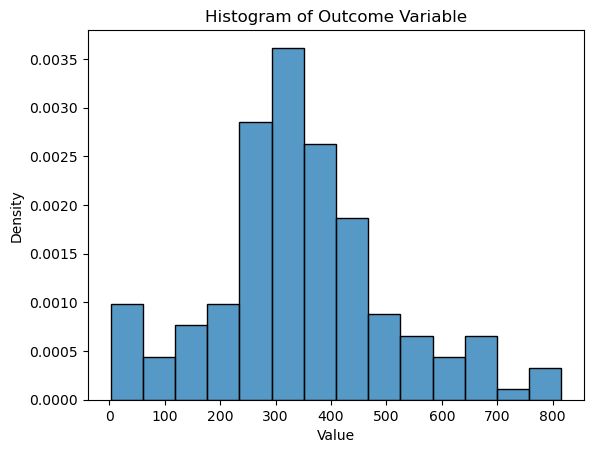

In [45]:
# Check mean and variance
counts = np.array(motion_weather_df['motion_count'])
mean = np.mean(counts)
variance = np.var(counts)
print(f"Mean: {mean}, Variance: {variance}")

# Plot histogram
sns.histplot(counts, kde=False, stat="density")
plt.title('Histogram of Outcome Variable')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


 The mean and variance are not the same, suggesting that a Poisson distribution may not be appropriate. We will further investigate using a chi-squared goodness-of-fit test.

In [46]:
# Frequencies of observed data
observed_freq = np.bincount(counts)

# Frequencies of expected data using Poisson distribution
expected_freq = [poisson.pmf(i, mean) * len(counts) for i in range(len(observed_freq))]

# Ensure observed and expected frequencies are of the same length
if len(expected_freq) > len(observed_freq):
    expected_freq = expected_freq[:len(observed_freq)]
else:
    expected_freq.extend([0] * (len(observed_freq) - len(expected_freq)))

# Chi-square test
chi2_stat, p_val = chisquare(f_obs=observed_freq, f_exp=expected_freq)
print(f"Chi2 Statistic: {chi2_stat}, p-value: {p_val}")


Chi2 Statistic: 3.865445660936478e+142, p-value: 0.0


 The chi-squared test indicates that we can reject the null hypothesis that the data follow a Poisson distribution. Next, we will test for normality.

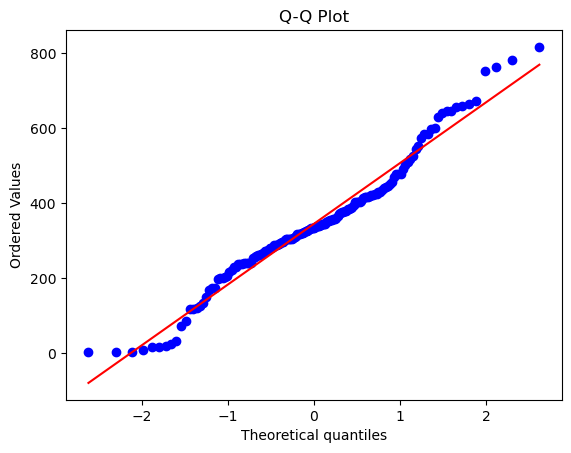

Shapiro-Wilk Test Statistic: 0.9701334834098816, p-value: 0.001752472948282957


In [47]:
# Q-Q plot
probplot(counts, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

# Shapiro-Wilk test
shapiro_stat, shapiro_p_value = shapiro(counts)
print(f"Shapiro-Wilk Test Statistic: {shapiro_stat}, p-value: {shapiro_p_value}")


 The Shapiro-Wilk test and Q-Q plot show that the data do not follow a normal distribution. We will now compare the likelihood functions for Poisson and Negative Binomial distributions.

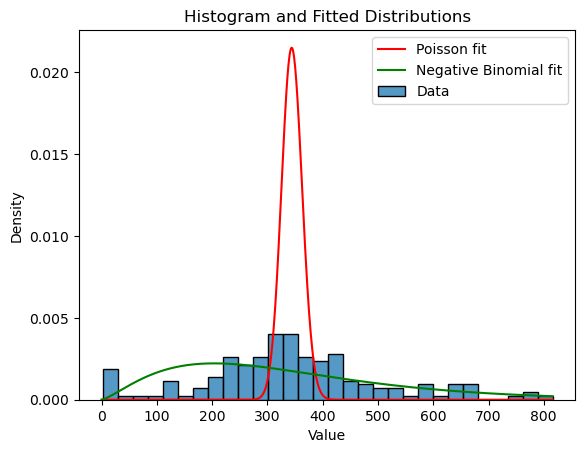

In [48]:
# Fit Negative Binomial distribution
def neg_binom_log_likelihood(params, counts):
    r, p = params
    return -np.sum(stats.nbinom.logpmf(counts, r, p))

# Initial guess for the parameters
initial_params = [1, 0.5]

# Fit Negative Binomial distribution
result = minimize(neg_binom_log_likelihood, initial_params, args=(counts,), bounds=((1e-5, None), (1e-5, 1-1e-5)))
neg_binom_r, neg_binom_p = result.x

# Plot histogram and fitted distributions
sns.histplot(counts, bins=30, kde=False, stat="density", label="Data")
x = np.arange(0, max(counts)+1)
plt.plot(x, poisson.pmf(x, mean), 'r-', label='Poisson fit')
plt.plot(x, stats.nbinom.pmf(x, neg_binom_r, neg_binom_p), 'g-', label='Negative Binomial fit')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram and Fitted Distributions')
plt.show()


 Based on the comparison, the Negative Binomial distribution fits the data better than the Poisson distribution.

 ## Perform Regression Analysis



 Now that we have determined that a Negative Binomial distribution is a better fit for our data, we will perform a Negative Binomial regression analysis to understand the relationship between motion counts and the weather variables (temperature and rain).

In [49]:
# Define the model formula
formula = 'motion_count ~ temperature_2m + rain'

# Fit the model using Negative Binomial regression
model = negativebinomial(formula, motion_weather_df).fit()

# Display the model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 6.655881
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
                     NegativeBinomial Regression Results                      
Dep. Variable:           motion_count   No. Observations:                  157
Model:               NegativeBinomial   Df Residuals:                      154
Method:                           MLE   Df Model:                            2
Date:                Thu, 06 Jun 2024   Pseudo R-squ.:                0.002204
Time:                        20:47:00   Log-Likelihood:                -1045.0
converged:                       True   LL-Null:                       -1047.3
Covariance Type:            nonrobust   LLR p-value:                   0.09939
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.0136     

 ## Scatterplots and Regression Lines



 We will visualize the relationship between temperature, rain, and motion events by creating scatter plots and overlaying the regression lines predicted by our model.

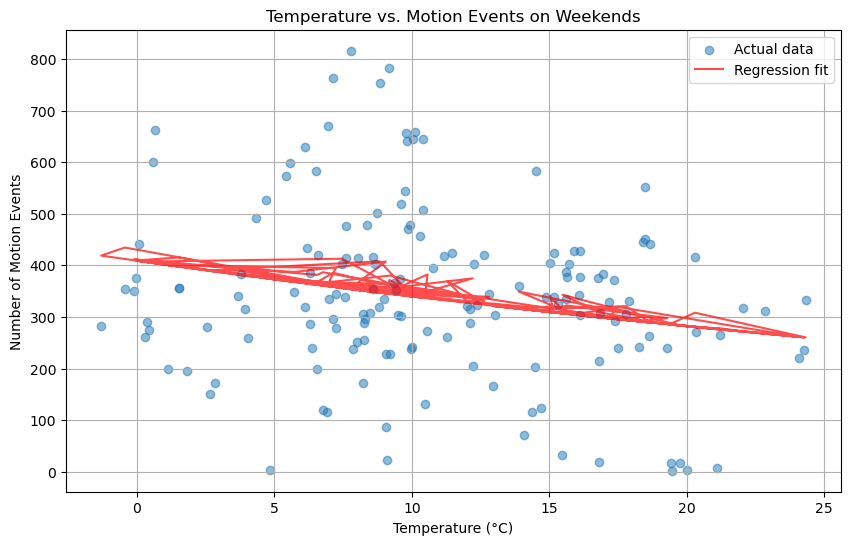

In [62]:
# Scatter plot for temperature vs. motion events
plt.figure(figsize=(10, 6))
plt.scatter(motion_weather_df['temperature_2m'], motion_weather_df['motion_count'], alpha=0.5, label='Actual data')

# Prepare the exogenous data for prediction
exog = pd.DataFrame({
    'temperature_2m': motion_weather_df['temperature_2m'],
    'rain': motion_weather_df['rain']
})

# Predict the values
predicted_motion_counts = model.predict(exog)

plt.plot(motion_weather_df['temperature_2m'], predicted_motion_counts, color='red', label='Regression fit', alpha=0.7)
plt.title('Temperature vs. Motion Events on Weekends')
plt.xlabel('Temperature (°C)')
plt.ylabel('Number of Motion Events')
plt.legend()
plt.grid(True)
plt.show()

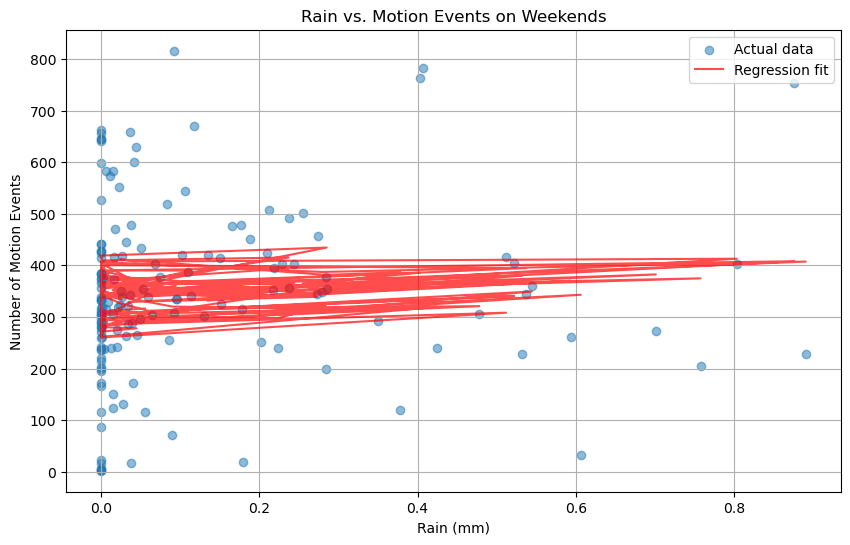

In [61]:
# Scatter plot for rain vs. motion events
plt.figure(figsize=(10, 6))
plt.scatter(motion_weather_df['rain'], motion_weather_df['motion_count'], alpha=0.5, label='Actual data')

# Predict the values for rain vs. motion events
predicted_motion_counts_rain = model.predict(exog)

plt.plot(motion_weather_df['rain'], predicted_motion_counts_rain, color='red', label='Regression fit', alpha=0.7)
plt.title('Rain vs. Motion Events on Weekends')
plt.xlabel('Rain (mm)')
plt.ylabel('Number of Motion Events')
plt.legend()
plt.grid(True)
plt.show()